In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys
import numpy.random as rnd

import tensorflow as tf
import gym

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:

env = gym.make("CartPole-v0")
obs = env.reset()
print(obs)
img = env.render(mode="rgb_array")

[2017-08-20 16:40:27,856] Making new env: CartPole-v0


[-0.0087426  -0.0074009  -0.01581592 -0.0140735 ]


In [3]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)
print("obs", obs, "done", done, "reward", reward, "info", info)

obs [-0.00889062  0.18794426 -0.01609739 -0.31170428] done False reward 1.0 info {}


In [4]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): # 1000 steps max, we don't want to run forever
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [5]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.473999999999997, 8.7887043413690957, 24.0, 67.0)

In [6]:


# 1. Specify the neural network architecture
n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4 # it's a simple task, we don't need more hidden neurons
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.contrib.layers.variance_scaling_initializer()
learning_rate = 0.01

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

In [7]:
y = 1. - tf.to_float(action)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []

for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
        for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
        for discounted_rewards in all_discounted_rewards]

In [9]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [10]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([ 1.26665318,  1.0727777 ])]

In [11]:
n_iterations = 2000
n_max_steps = 1000
n_games_per_update = 10 
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("Epoch", iteration)
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode

        for game in range(n_games_per_update):
            current_rewards = [] # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
            obs = env.reset()
            env.render()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run( [action, gradients],
                    feed_dict={X: obs.reshape(1, n_inputs)}) # one obs

                obs, reward, done, info = env.step(action_val[0][0])
                env.render()
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards,discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean( [reward * all_gradients[game_index][step][var_index]
                for game_index, rewards in enumerate(all_rewards)
                for step, reward in enumerate(rewards)],
                axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        print("upgrading gradiants")
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0: saver.save(sess, "./my_policy_net_pg.ckpt")

Epoch 0
upgrading gradiants
Epoch 1
upgrading gradiants
Epoch 2
upgrading gradiants
Epoch 3
upgrading gradiants
Epoch 4


KeyboardInterrupt: 

In [2]:

env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

[2017-08-20 19:29:22,684] Making new env: MsPacman-v0


(210, 160, 3)

In [3]:
mspacman_color = np.array([210, 164, 74]).mean()

In [4]:
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.mean(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


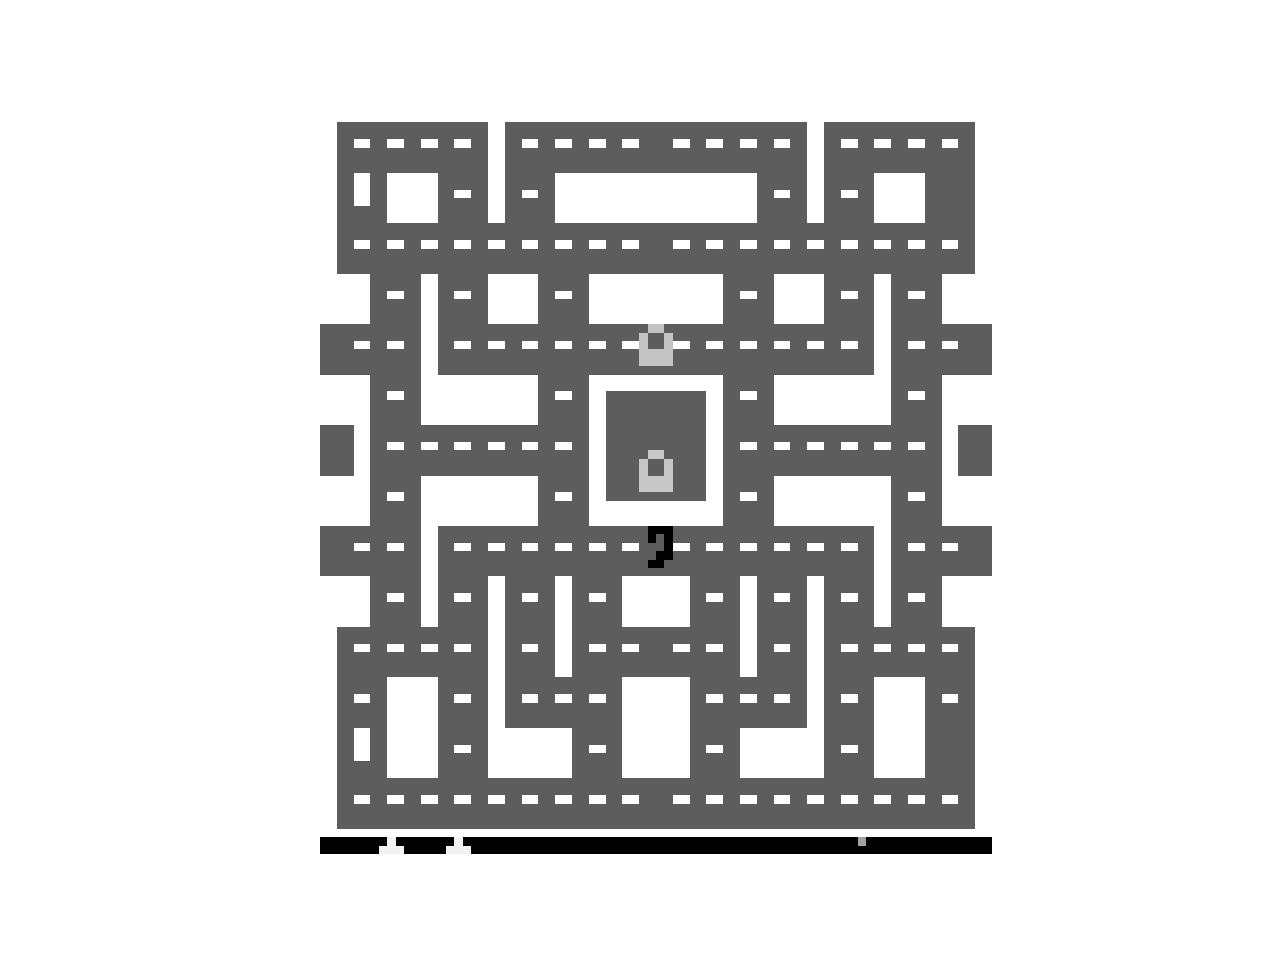

In [5]:
plt.imshow(img.reshape(88,80),interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [6]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n # 9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()


def q_network(X_state, name):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, stride, padding, activation in zip(conv_n_maps, conv_kernel_sizes, conv_strides,
                                                                    conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps, kernel_size=kernel_size,
                                          strides=stride, padding=padding, activation=activation,
                                          kernel_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])

actor_q_values, actor_vars = q_network(X_state, name="q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, name="q_networks/critic")

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [7]:
learning_rate = 0.01

X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs), axis=1, keep_dims=True)

y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
# replay memory

from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))

In [9]:
# epsilon greedy policy 

eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [14]:
n_steps = 100000 # total number of training steps
training_start = 1000 # start training after 1,000 game iterations
training_interval = 3 # run a training step every 3 game iterations
save_steps = 50 # save the model every 50 training steps
copy_steps = 25 # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90 # skip the start of every game (it's just waiting time)
batch_size = 50
iteration = 0 # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset
render = True

from gym.envs.classic_control import rendering
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            #print "Number of repeats must be larger than 0, k: {}, l: {}, returning default array!".format(k, l)
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

viewer = rendering.SimpleImageViewer()

def render(env):
    rgb = env.render('rgb_array')
    upscaled=repeat_upsample(rgb,4, 4)
    viewer.imshow(upscaled)


with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
            
        iteration += 1
        if done: # game over, start again
            obs = env.reset()
            if render:
                render(env)
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
                if render:
                    render(env)
            state = preprocess_observation(obs)

        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Actor plays
        obs, reward, done, info = env.step(action)
        print(reward)
        if render:
            render(env)
        next_state = preprocess_observation(obs)

        # Let's memorize what just happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        if iteration < training_start or iteration % training_interval != 0:
            continue
            
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = actor_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        training_op.run(feed_dict={X_state: X_state_val,
                                    X_action: X_action_val, y: y_val})

        # Regularly copy critic to actor
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
        
        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
200.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

KeyboardInterrupt: 